In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

from sklearn import linear_model, decomposition, datasets
from sklearn.preprocessing import StandardScaler

In [2]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('data_movies/dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('data_movies/dataTesting.csv', encoding='UTF-8', index_col=0)

In [3]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,"most is the story of a single father who takes his eight year - old son to work with him at the railroad drawbridge where he is the bridge tender . a day before , the boy meets a woman boarding a train , a drug abuser . at the bridge , the father goes into the engine room , and tells his s...","['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets of his satisfying career to a video store clerk .,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfiguring facial scar meets a gentleman who lives beyond his means . they become accomplices in blackmail , and she falls in love with him , bitterly resigned to the impossibility of his returning her affection . her life changes when one of her vic...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the president of the tredway corporation avery bullard has just had a meeting with investment bankers and sends a telegram scheduling a meeting at the furniture factory in millburgh , pennsylvania , at six pm with his executives . bullard has never appoint...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing house carol hunnicut goes to a blind date with the lawyer michael tarlow , who has embezzled the powerful mobster leo watts . carol accidentally witnesses the murder of michel by leo ' s hitman . the scared carol sneaks out of michael ' s room and ...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate . theresa osborne is running along the beach when she stumbles upon a bottle washed up on the shore . inside is a message , reading the letter she feels so moved and yet she felt as if she has violated someone ' s thoughts . in love with a man she..."
4,1978,Midnight Express,"the true story of billy hayes , an american college student who is caught smuggling drugs out of turkey and thrown into prison ."
5,1996,Primal Fear,"martin vail left the chicago da ' s office to become a successful criminal lawyer , that success predicated on working on high profile cases . as such , he fights to get the case of naive nineteen year old rural kentuckian aaron stampler , an altar boy accused of the vicious bludgeoning deat..."
6,1950,Crisis,"husband and wife americans dr . eugene and mrs . helen ferguson - he a renowned neurosurgeon - are traveling through latin america for a vacation . when they make the decision to return to new york earlier than expected , they find they are being detained by the military in the country t..."
7,1959,The Tingler,"the coroner and scientist dr . warren chapin is researching the shivering effect of fear with his assistant david morris . dr . warren is introduced to ollie higgins , the relative of a criminal sentenced to the electric chair , while making the autopsy of the corpse , and he makes a comme..."


In [5]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [6]:
dataTraining['clean_plot'] = dataTraining['plot'].apply(lambda x: clean_text(x))
dataTesting['clean_plot'] = dataTesting['plot'].apply(lambda x: clean_text(x))

In [7]:
# Outliers
dataTraining['clean_plot_length']=dataTraining['clean_plot'].apply(lambda x:len(x))  # calculate length of cleaned text
dataTraining.head()

(dataTraining['clean_plot_length']>1504).value_counts()

# Remove extremely long descriptions: outliers
print('Dataframe size (before removal): ',len(dataTraining))
filt=dataTraining['clean_plot_length']>1504
dataTraining.drop(dataTraining[filt].index,axis=0,inplace=True)     # filter rows having cleaned description length > 2000
print('Dataframe size (after removal): ',len(dataTraining))
print(f'Removed rows: {filt.sum()}')

Dataframe size (before removal):  7895
Dataframe size (after removal):  7390
Removed rows: 505


In [8]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()

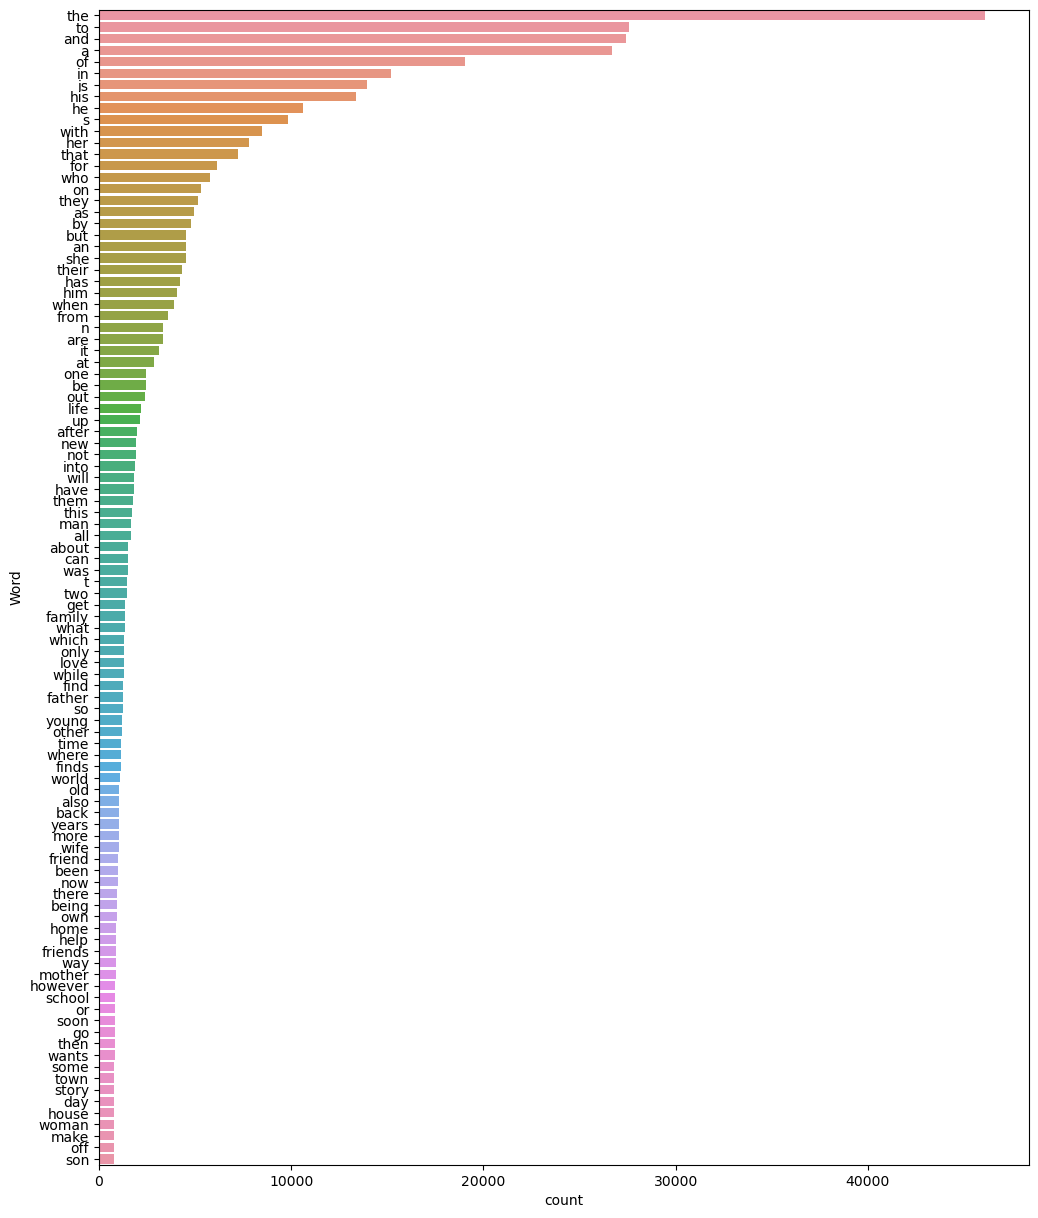

In [9]:
# print 100 most frequent words 
freq_words(dataTraining['clean_plot'], 100)

In [10]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

dataTraining['clean_plot'] = dataTraining['clean_plot'].apply(lambda x: remove_stopwords(x))
dataTesting['clean_plot'] = dataTesting['clean_plot'].apply(lambda x: remove_stopwords(x))

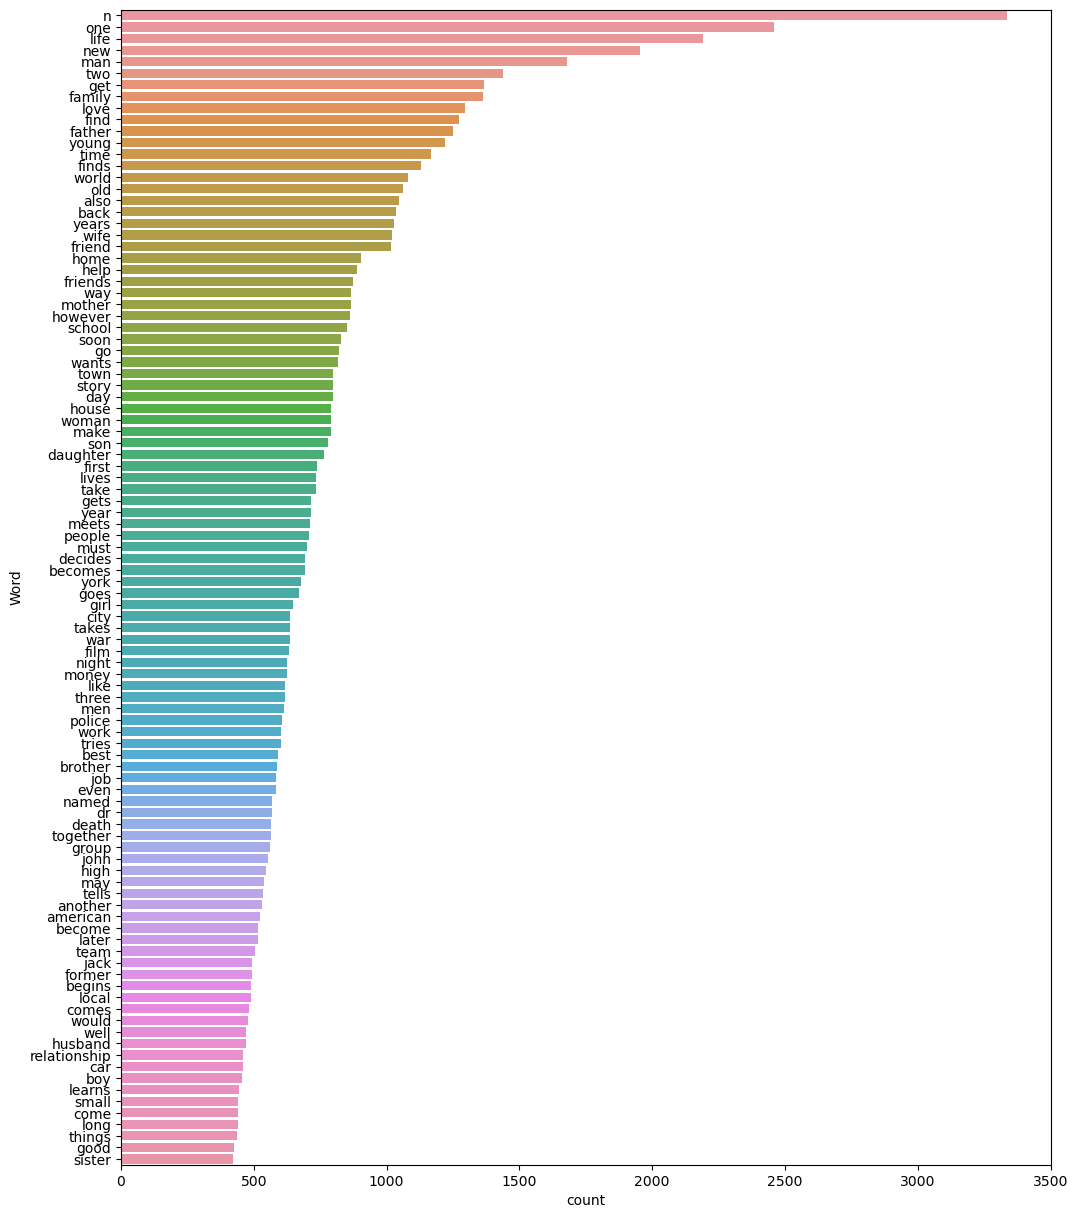

In [11]:
freq_words(dataTraining['clean_plot'], 100)

In [12]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y = le.fit_transform(dataTraining['genres'])

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, sublinear_tf=True, smooth_idf=False)

In [14]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(dataTraining['clean_plot'], y, test_size=0.2, random_state=9)

In [15]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

### Hyperparameter Tuning

In [16]:
# dict_params = {}
# max_mcauc = 0

# solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
# penalty = ['l1','l2','elasticnet']
# c_values = [100, 10, 1.0, 0.1, 0.01]

# for s in solver:
#     for p in penalty:
#         for c in c_values:
#             try:
#                 lr = LogisticRegression(solver=s, penalty=p, C=c, max_iter=100000, verbose=0)
#                 clf = OneVsRestClassifier(lr)
#                 clf.fit(xtrain_tfidf, ytrain)
#                 # predict probabilities
#                 y_pred_prob = clf.predict_proba(xval_tfidf)

#                 if max_mcauc == 0: 
#                     max_mcauc = round(roc_auc_score(yval, y_pred_prob, average='macro'),3)
#                     item = {'mcauc': max_mcauc, 'solver':s, 'penalty': p, 'c_values': c}
#                     dict_params.update(item)
#                 else:
#                     if round(roc_auc_score(yval, y_pred_prob, average='macro'),3) > max_mcauc:
#                         max_mcauc = round(roc_auc_score(yval, y_pred_prob, average='macro'),3)
#                         item = {'mcauc': max_mcauc, 'solver':s, 'penalty': p, 'c_values': c}
#                         dict_params.update(item)
#             except:
#                 pass

# print(f'Best Params: { dict_params }')

In [17]:
lr = LogisticRegression(solver='liblinear', penalty='l2')
clf = OneVsRestClassifier(lr)

In [18]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

In [19]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [20]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [21]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.5728853444894757

In [22]:
# # Impresión del desempeño del modelo
roc_auc_score(yval, y_pred_prob, average='macro')

0.9051273132814126

In [23]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = tfidf_vectorizer.transform(dataTesting['clean_plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [24]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.125692,0.093733,0.037366,0.031377,0.370930,0.140061,0.037434,0.510903,0.074187,0.122537,...,0.033065,0.109298,0.001995,0.456928,0.060941,0.011409,0.027312,0.176000,0.028056,0.029470
4,0.119507,0.056009,0.030964,0.119751,0.259438,0.260902,0.064137,0.805479,0.041773,0.040737,...,0.031268,0.055235,0.002191,0.106534,0.030734,0.013084,0.034913,0.274386,0.048139,0.029539
5,0.119404,0.039022,0.017340,0.052149,0.153833,0.556457,0.032344,0.776158,0.033787,0.044167,...,0.022105,0.230558,0.002135,0.183736,0.044580,0.009997,0.026834,0.458977,0.034593,0.019009
6,0.122597,0.093811,0.025754,0.037651,0.195861,0.093087,0.031438,0.692089,0.059434,0.057198,...,0.032378,0.104888,0.001923,0.204266,0.131681,0.009821,0.032018,0.336754,0.052945,0.025995
7,0.080130,0.092739,0.031425,0.034885,0.266552,0.111855,0.045409,0.409621,0.060539,0.126744,...,0.026940,0.104380,0.002049,0.168477,0.266106,0.011444,0.020094,0.318161,0.022884,0.025564


### Inference Function

In [25]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return le.inverse_transform(q_pred)

In [26]:
for i in range(3): 
    k = xval.sample(1).index[0] 
    print("Movie: ", dataTraining['title'][k], "\nPredicted genre: ", infer_tags(xval[k])), 
    print("Actual genre: ",dataTraining['genres'][k], "\n")

Movie:  The Trials of Cate McCall 
Predicted genre:  [('Drama',)]
Actual genre:  ['Drama'] 

Movie:  Simon Says 
Predicted genre:  [()]
Actual genre:  ['Horror', 'Thriller'] 

Movie:  Bigger Stronger Faster* 
Predicted genre:  [()]
Actual genre:  ['Documentary', 'Sport'] 

